# Угадай знаменитость

## Загрузка библиотек и данных для обучения

In [3]:
import torch
import random
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os
from PIL import Image

In [4]:
# Проверяем доступность GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device:', device)

Using device: cuda


In [5]:
# Задаем пути к директориям с данными
data_dir = 'data'
train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'valid')

In [6]:
# Преобразование данных
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Загрузка данных из директорий
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}

In [7]:
image_datasets['train'].classes

['bill_gates', 'elon_musk', 'jeff_bezos', 'mark_zuckerberg', 'steve_jobs']

In [8]:
image_datasets['valid'].classes

['bill_gates', 'elon_musk', 'jeff_bezos', 'mark_zuckerberg', 'steve_jobs']

In [9]:
class_names = image_datasets['train'].classes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

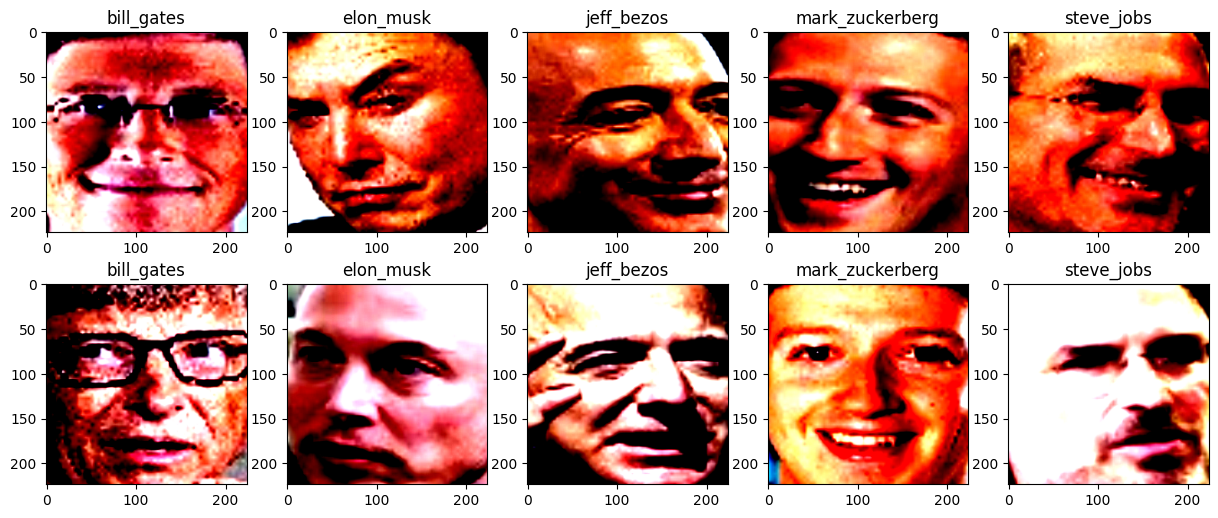

In [10]:
# Выводим по одному изображению из каждого класса
fig, axs = plt.subplots(2, 5, figsize=(15, 6))

for i in range(5):
    class_images = [img for img, label in image_datasets['train'] if label == i]
    random_image = random.choice(class_images)
    axs[0, i].imshow(np.transpose(random_image, (1, 2, 0)))
    axs[0, i].set_title(class_names[i])

    specific_image = [img for img, label in image_datasets['valid'] if label == i][0]
    axs[1, i].imshow(np.transpose(specific_image, (1, 2, 0)))
    axs[1, i].set_title(class_names[i])

plt.show()

## Загрузка и доработка модели

In [11]:
# Загрузка предобученной модели
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 5)  # заменяем последний слой на новый, соответствующий количеству классов
model = model.to(device)

# Определение функции потерь и оптимизатора
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

c:\Users\alex_\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\alex_\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\alex_/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100.0%


In [12]:
# Обучение модели
num_epochs = 5
for epoch in range(num_epochs):
    for phase in ['train', 'valid']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

train Loss: 0.9593 Acc: 0.6857
valid Loss: 0.3130 Acc: 0.9344
train Loss: 0.4705 Acc: 0.8583
valid Loss: 0.1195 Acc: 0.9726
train Loss: 0.3054 Acc: 0.9137
valid Loss: 0.0738 Acc: 0.9836
train Loss: 0.2315 Acc: 0.9333
valid Loss: 0.0427 Acc: 0.9902
train Loss: 0.1825 Acc: 0.9490
valid Loss: 0.0493 Acc: 0.9869


## Тестируем модель

In [13]:
# Предобработка изображения
data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [14]:
# Загрузка и предобработка тестового изображения
input_image = Image.open('mask.jpg')
input_tensor = data_transforms(input_image)
input_batch = input_tensor.unsqueeze(0)  # добавляем размерность пакета

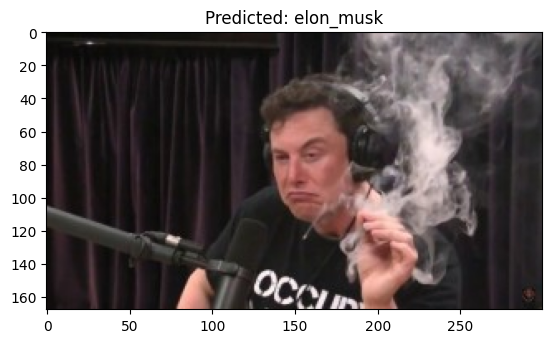

In [15]:

# Перемещаем входной тензор на устройство (GPU или CPU)
input_batch = input_batch.to(device)

# Модель предсказания
model.eval()
with torch.no_grad():
    output = model(input_batch)

# Получаем предсказание
_, predicted = torch.max(output, 1)

# Выводим результат
plt.imshow(input_image)
plt.title('Predicted: {}'.format(class_names[predicted]))
plt.show()

In [16]:
# Загрузка и предобработка тестового изображения
input_image = Image.open('elon.jpg')
input_tensor = data_transforms(input_image)
input_batch = input_tensor.unsqueeze(0)  # добавляем размерность пакета

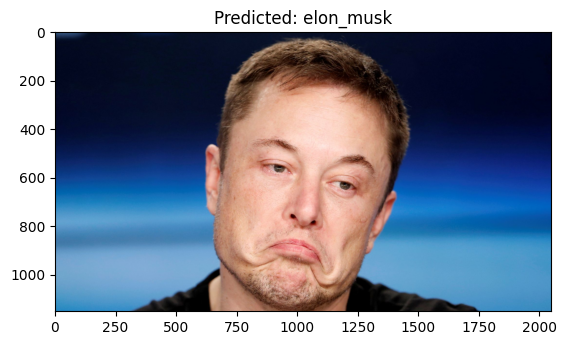

In [17]:
# Перемещаем входной тензор на устройство (GPU или CPU)
input_batch = input_batch.to(device)

# Модель предсказания
model.eval()
with torch.no_grad():
    output = model(input_batch)

# Получаем предсказание
_, predicted = torch.max(output, 1)

# Выводим результат
plt.imshow(input_image)
plt.title('Predicted: {}'.format(class_names[predicted]))
plt.show()